## Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Расшифровка полей данных
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

План работы:
- Провести предобработку данных (проверить типы, пропуски, дубликаты, аномальные значения)
- Исследовать данные (изучить различные зависимости, построить предварительные выводы)
- Провести подготовку данных к моделированию (исследовать баланс классов, исключение признаков, нормализовать данные)
- Построение моделей и оптимизация их гиперпараметров
- Выбор итоговой модели и вывод

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, classification_report, roc_auc_score,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier,Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [2]:
phone = pd.read_csv('/Users/kostyabykov/Desktop/final_provider/phone.csv')
personal = pd.read_csv('/Users/kostyabykov/Desktop/final_provider/personal.csv')
internet = pd.read_csv('/Users/kostyabykov/Desktop/final_provider/internet.csv')
contract = pd.read_csv('/Users/kostyabykov/Desktop/final_provider/contract.csv')

In [4]:
display(personal.head())
print("Кол-во строк:", personal.shape[0])

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Кол-во строк: 7043


In [5]:
display(contract.head())
print("Кол-во строк:", contract.shape[0])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Кол-во строк: 7043


In [6]:
display(phone.head())
print("Кол-во строк:", phone.shape[0])

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Кол-во строк: 6361


In [7]:
display(internet.head())
print("Кол-во строк:", internet.shape[0])

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Кол-во строк: 5517


In [8]:
# Объединим все таблицы в одну
df = contract.merge(personal, how='left', on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Присутствуют пропуски в последних 8 столбцах, рассмотрим эти столбцы подробней, чтобы понять как их обработать

In [10]:
# Рассмотрим данные внутри каждого столбца
for column in df.columns[2:]:
    print("Столбец:", column)
    print(df[column].value_counts())
    print('\n')

Столбец: EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64


Столбец: Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Столбец: PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64


Столбец: PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


Столбец: MonthlyCharges
20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 1585, dtype: int64


Столбец: TotalCharges
20.2       11
           11
19.75       9
20.05       8
19.65       8
           ..
3772.65     1
42.45       1
1810.55     1
3431.75     1
374         1
Name: TotalCharges, Lengt

In [11]:
# Присутствуют пустые значения в столбце TotalCharges у новых пользователей
df.sort_values(by='TotalCharges').head(12)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN


In [12]:
print("Кол-во дубликатов:", df.duplicated().sum())

Кол-во дубликатов: 0


#### Вывод
На этапе предобработки данных можно сделать следующие выводы:
- в данных присутствуют пропуски;
- в столбце TotalCharges для новых пользователей присвоено пустое значение, а сам столбец перевести в тип float;
- следует изменить тип столбцов BeginDate, EndDate в datetime; 
- дубликаты отсутствуют;
- столбец EndDate содержит 5 уникальных значений, среди которых большинство "No".

### Обработаем значения

In [13]:
# Обработаем пустые значения в TotalCharges и изменим тип данных
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: 0 if x == ' ' else x)
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [14]:
# Заменим значения NO в столбце EndDate на текущую дату (1 февраля 2020),
# чтобы в дальнейшем просчитать длительность контракта кажого уникального пользователя
# также создадим столбец таргет с значением 1, если клиент разорвал договор

df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
df['target'] = df['EndDate'].apply(lambda x: 0 if x == '2020-02-01' else 1)

df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [15]:
df['EndDate'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [16]:
# Просчитаем длительность пользования услугами
df['DeltaDays'] = (df['EndDate'] - df['BeginDate']).dt.days
df['DeltaDays'] = df['DeltaDays'].astype('int')

In [17]:
# Исходя из бизнес логики данных пропущенные значения в данных столбцах означают, 
# что клиент не пользуется данной услугой, поэтому заменим пропуски на 0
col_fillna = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'DeltaDays']
for column in col_fillna:
    df[column] = df[column].fillna(0)
    
df['InternetService'] = df['InternetService'].fillna('Undefined')

In [18]:
# Преобразуем все значения вида Yes-No в числа, а также Gender
col_yes_no = ['PaperlessBilling', 'Partner', 'OnlineSecurity', 'OnlineBackup','DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Dependents']
for column in col_yes_no:
    df[column] = df[column].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else x)
    df[column] = df[column].astype('int')
    
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0 if x == 'Female' else x)

In [19]:
# Рассмотрим данные внутри каждого столбца
for column in df.columns[2:]:
    print("Столбец:", column)
    print(df[column].value_counts())
    print('\n')

Столбец: EndDate
2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64


Столбец: Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Столбец: PaperlessBilling
1    4171
0    2872
Name: PaperlessBilling, dtype: int64


Столбец: PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


Столбец: MonthlyCharges
20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: MonthlyCharges, Length: 1585, dtype: int64


Столбец: TotalCharges
0.00       11
20.20      11
19.75       9
19.90       8
20.05       8
           ..
6668.35     1
6096.90     1
140.70      1
797.10      1
5867.00     1
Name: TotalCharges, Length: 6531, dtype: int64


Столбец: gender
1    3555

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   int64         
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   int64         
 14  OnlineBackup      7043 n

### Вывод
На этапе обработки данных были сделаны следующие шаги:
- обработаны все пропуски;
- просчитан срок жизни кажого контракта;
- часть катгориальных значений были преобразованы;
- создали столбец target c признаком 1, если клиент разорвал догвор.

## Исследование данных

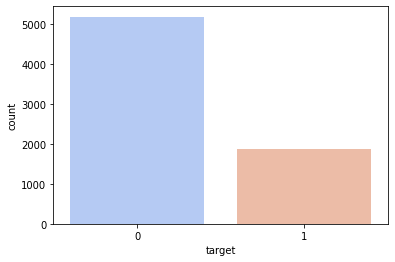

Кол-во ушедших клиентов: 1869
Кол-во текущих клиентов: 5174


In [21]:
sns.countplot(x='target', data=df,palette='coolwarm')
plt.show()
print('Кол-во ушедших клиентов:', len(df[df['target']==1]))
print('Кол-во текущих клиентов:', len(df[df['target']==0]))

In [22]:
# Разделим столбцы на 3 категории: бинарные(0 или 1), категориальные, числовые для удобного построения графиков

binary_features = df[['PaperlessBilling', 'gender','SeniorCitizen', 'Partner', 'Dependents',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'MultipleLines', 'target']]
features_triple = df[['InternetService', 'Type', 'PaymentMethod', 'target']]
features_num = df[['MonthlyCharges', 'TotalCharges','DeltaDays', 'target']]


binary_features_1 = binary_features[binary_features['target']==1]
binary_features_0 = binary_features[binary_features['target'] == 0]

features_num_1 = features_num[features_num['target']==1]
features_num_0 = features_num[features_num['target']==0]

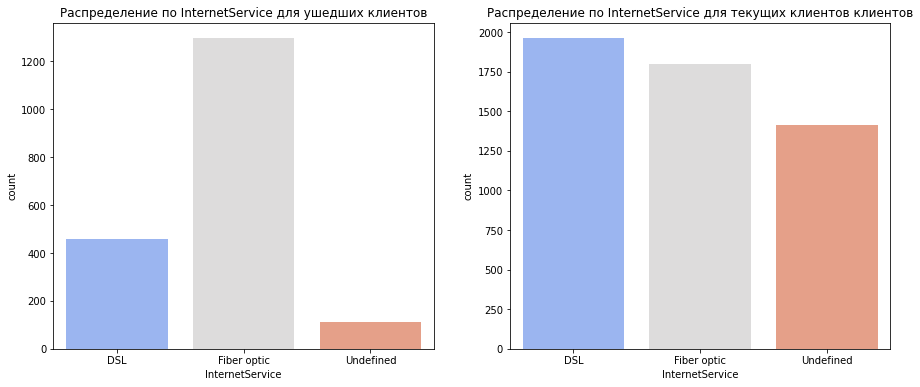

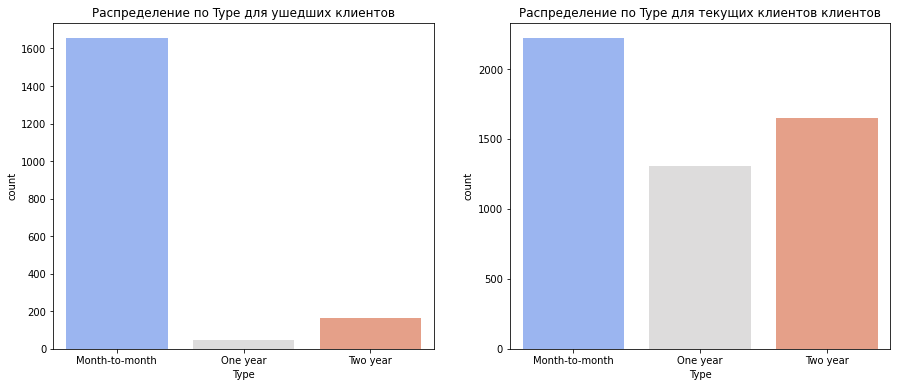

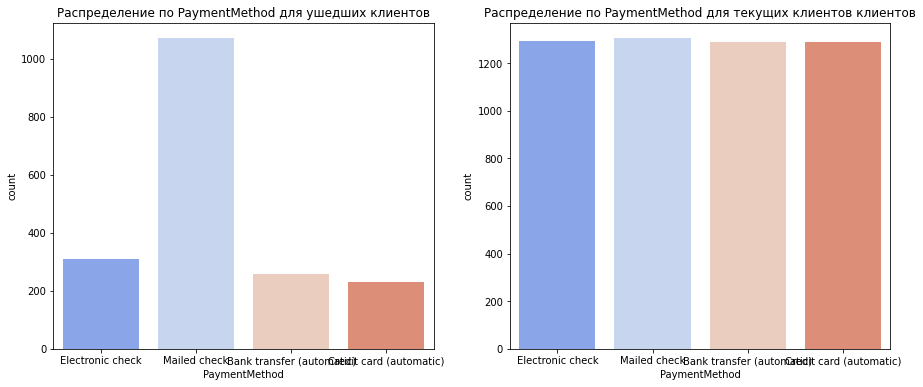

In [23]:
# Построим распределение для категориальных категорий
for column in ['InternetService', 'Type', 'PaymentMethod']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.countplot(x=column, data=features_triple[features_triple['target']==1], ax=axes[0],palette='coolwarm')
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.countplot(x=column, data=features_triple[features_triple['target']==0], ax=axes[1],palette='coolwarm')
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    #sns.countplot(x=column, data=features_triple, ax=axes[2],palette='coolwarm')
    #axes[2].set_title('Распределение по ' + column + ' для всех')
    plt.show()

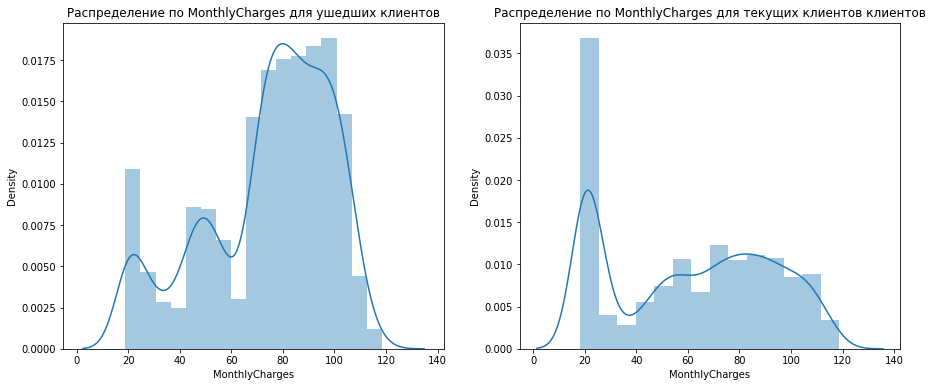

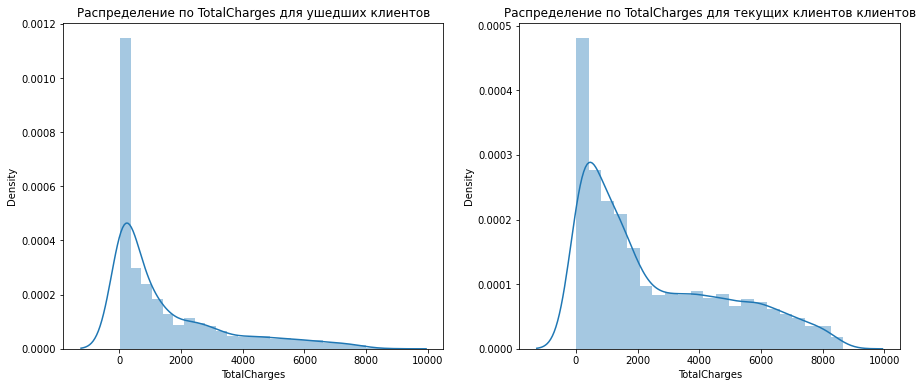

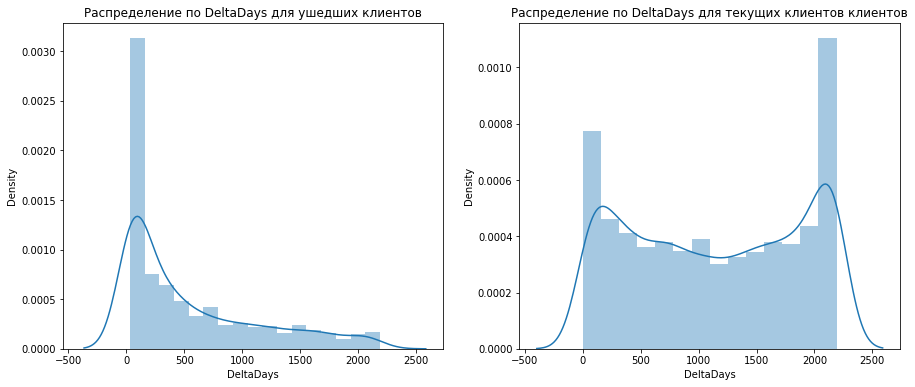

In [24]:
# Пострим расапределение для числовых категорий
for column in ['MonthlyCharges', 'TotalCharges','DeltaDays']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.distplot(features_num_1[column], ax=axes[0])
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.distplot(features_num_0[column], ax=axes[1])
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    plt.show()

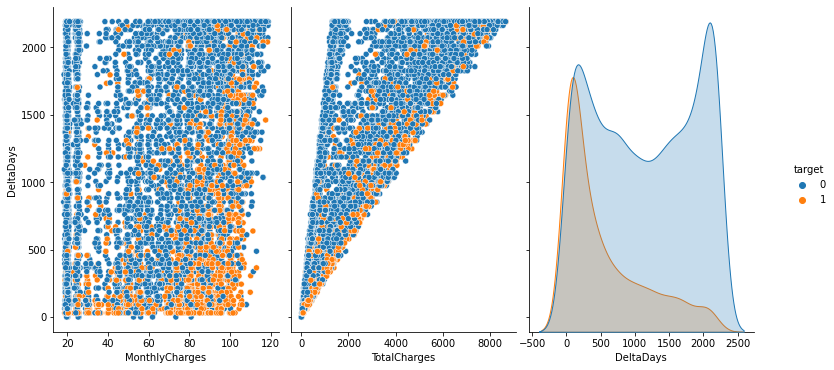

In [25]:
sns.pairplot(data = features_num, 
             x_vars=['MonthlyCharges', 'TotalCharges','DeltaDays'],
             y_vars=["DeltaDays"],
             hue='target').fig.set_size_inches(12,6)

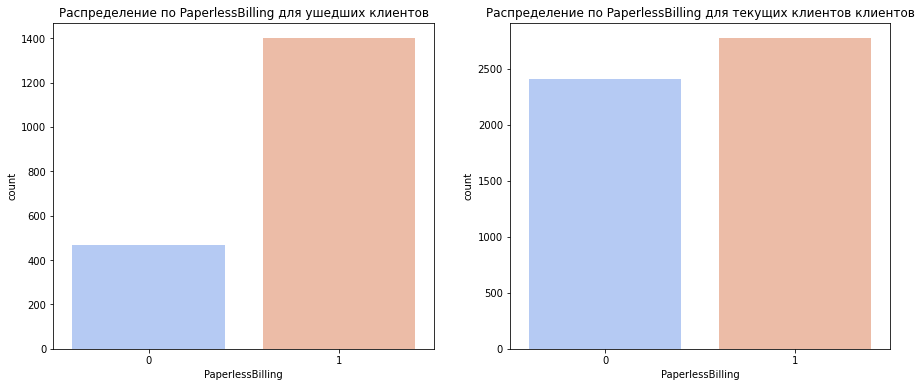

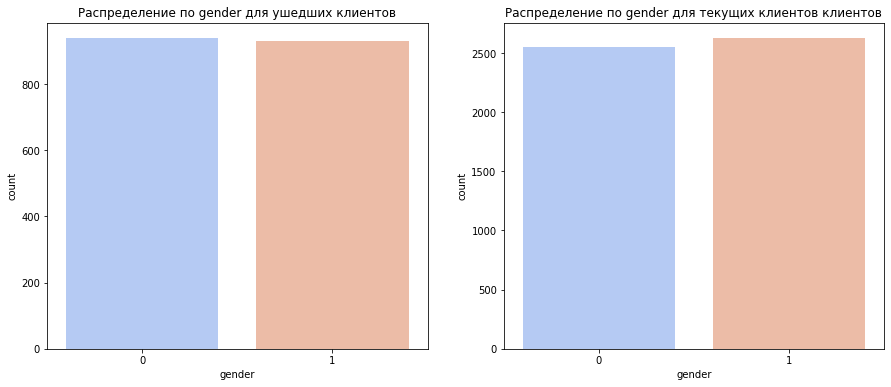

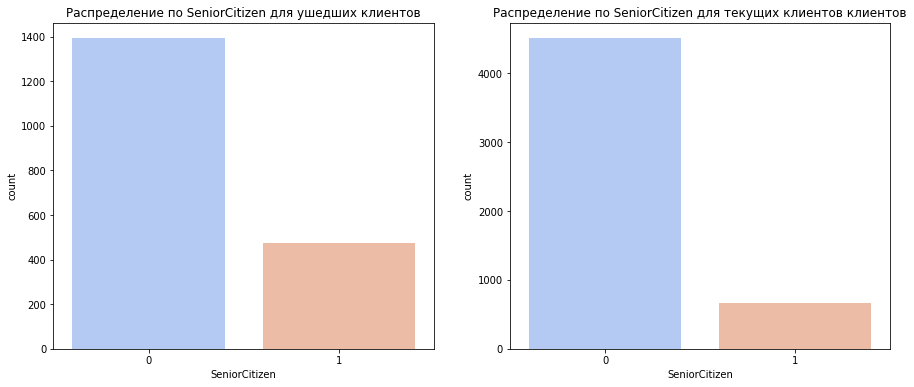

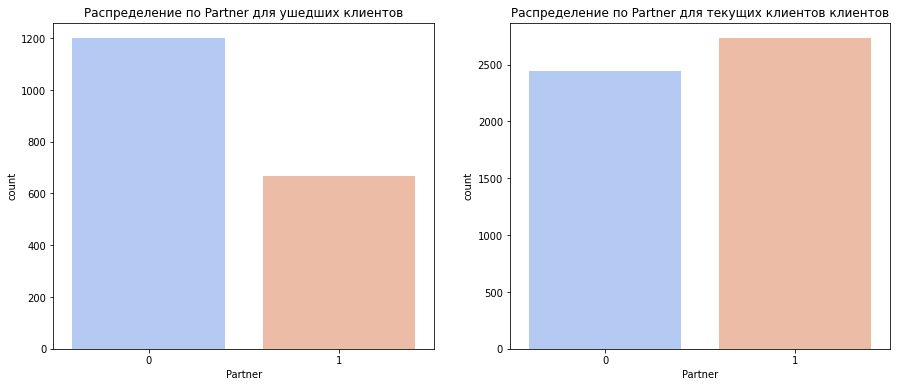

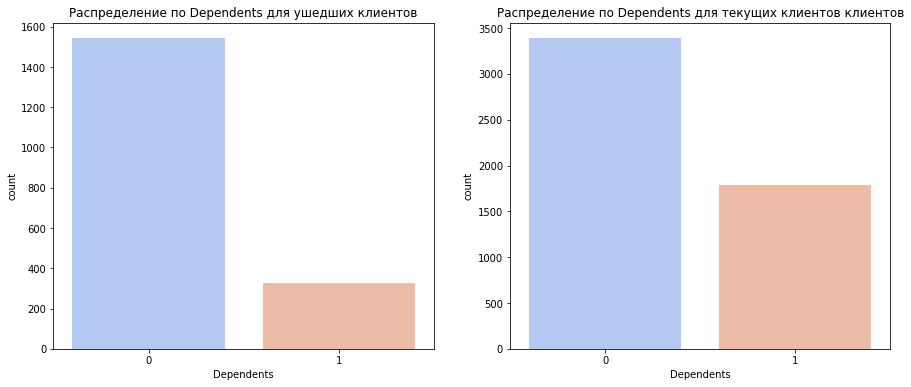

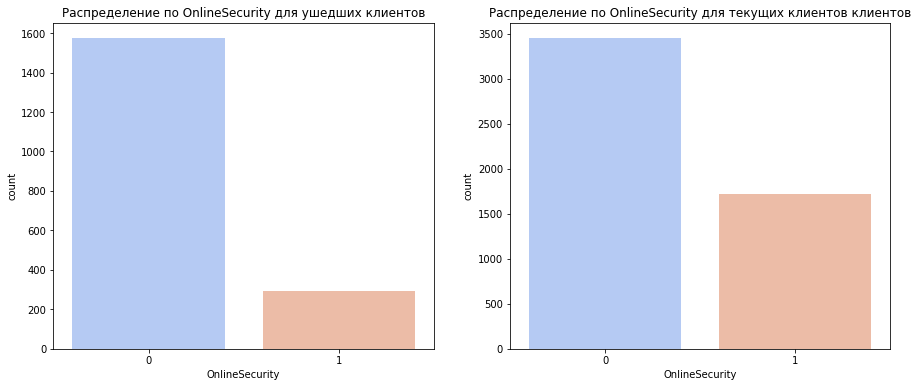

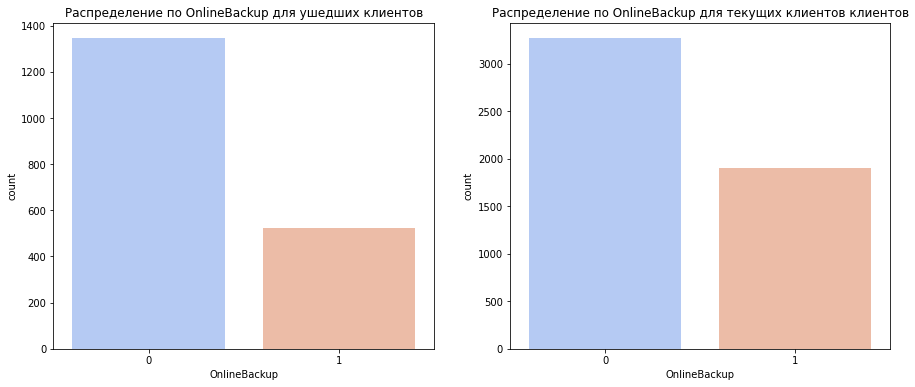

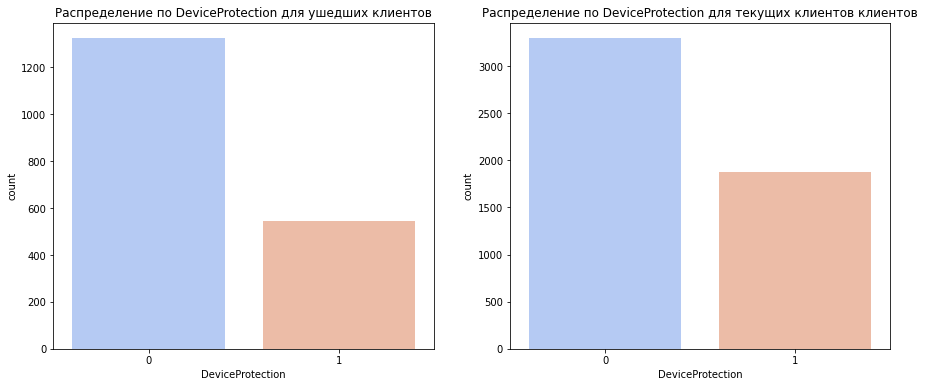

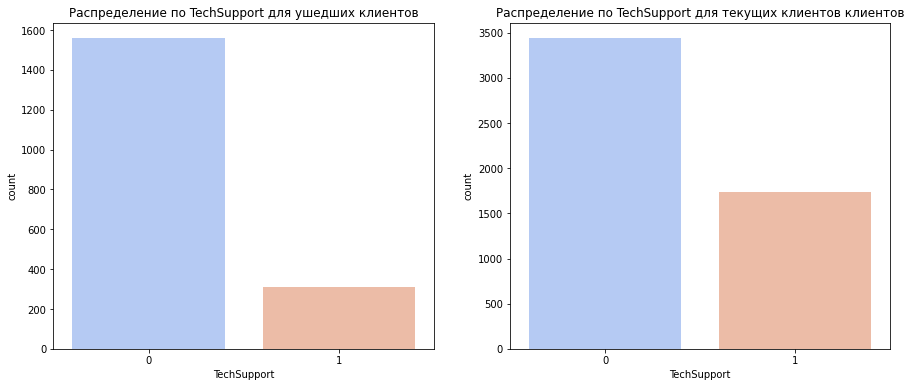

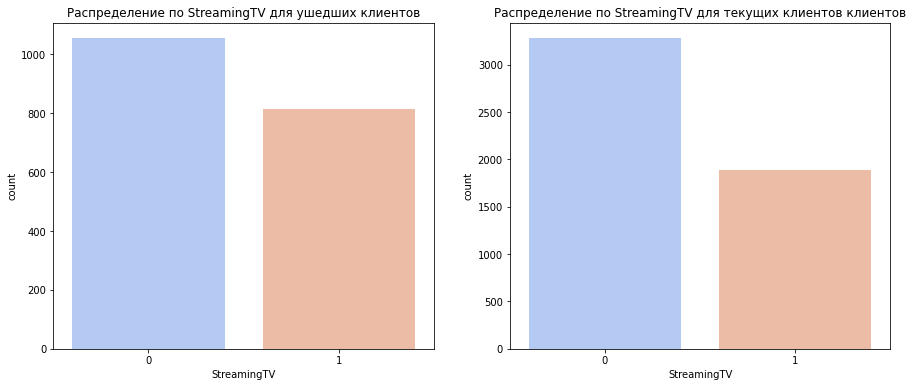

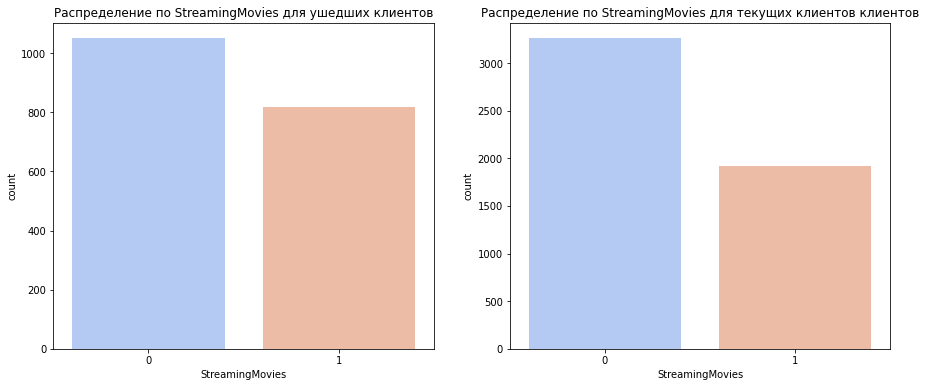

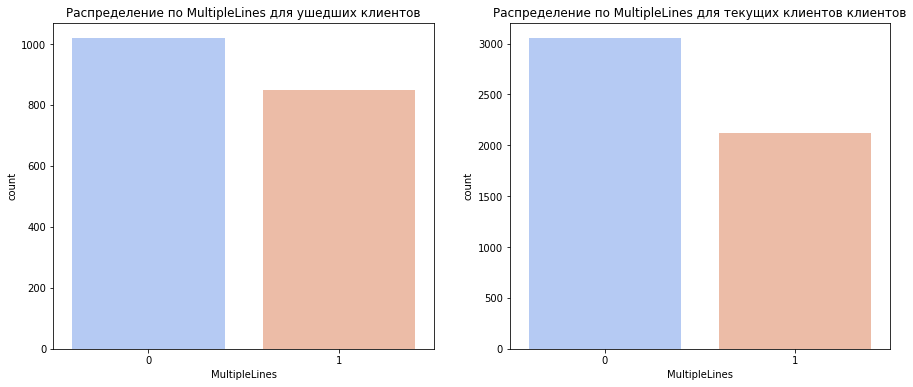

In [26]:
# Пострим расапределение для бинарных категорий
for column in ['PaperlessBilling', 'gender','SeniorCitizen', 'Partner', 'Dependents',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'MultipleLines']:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))
    sns.countplot(x=column, data=binary_features_1, ax=axes[0],palette='coolwarm')
    axes[0].set_title('Распределение по ' + column + ' для ушедших клиентов')
    sns.countplot(x=column, data=binary_features_0, ax=axes[1],palette='coolwarm')
    axes[1].set_title('Распределение по ' + column + ' для текущих клиентов клиентов')
    plt.show()

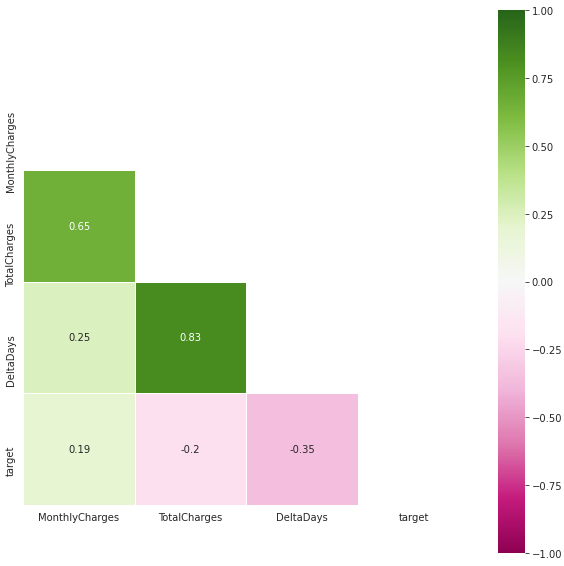

In [27]:
# Рассмотрим корреляцию признаков
corr = features_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, annot = True, mask=mask, vmax=1, vmin=-1,
                     center=0, square=True, linewidths=.5,cmap="PiYG")

### Вывод
На этапе исследования данных мы пришли к выводу, что данные несбалансирваны, кол-во ушедших клиентов 1869, кол-во текущих клиентов 5174. А также выдвинули гипотезы:
- распределение типа подключения интернета для текущих клиентов примерно равное, однако большинство ушедших клиентов пользовались оптоволоконным кабелем
- доля ушедших клиентов, которые пользовались ежемесячной оплатой услуг намного больше аналогичной доли текущих клиентов
- распределение способа оплаты для текущих клиентов примерно равное, но ушедшие клиенты чаще оплачивали счета почтовыми переводами
- большинство ушедших клиентов имели высокий ежемесячный платеж 60-100 долл
- большинство ушедших клиентов разорвали договор в первый год пользования
- ушедшие клиенты чаще текущих клиентов пользовались безналичной оплатой
- ушедшие клиенты реже текущих имеют супруга(у) и иждивенцев
- ушедшие клиенты реже текущих пользовались блокировкой небезопасных сайтов, антивирусом и тех. поддерджкой, возможно это именно те доп. услуги, которые заставляют клиента остаться с компанией
- ушедшие клиенты чаще текущих пользовались стриминговыми сервисами, возможно их не устраивал текущий сервис по данной услуге и это поспособствовало их уходу

## Подготовка данных для моделирования

In [28]:
# Удалим ненужные столбцы

df=df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [29]:
# Проведем OHE кодирование
df_ohe = pd.get_dummies(df, drop_first=True)

In [30]:
# Разобьем выборку на трейн и тест с учетом баланса классов
X = df_ohe.drop('target', axis=1)
y = df_ohe['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=12345, stratify=y)
print("Баланс классов полного датасета:",len(y[y == 1])/len(y))
print("Баланс классов обучающего датасета:",len(y_train[y_train == 1])/len(y_train))
print("Баланс классов тестового датасета:",len(y_test[y_test == 1])/len(y_test))

Баланс классов полного датасета: 0.2653698707936959
Баланс классов обучающего датасета: 0.2653144016227181
Баланс классов тестового датасета: 0.26549929010885


In [31]:
# Масштабируем числовые признаки, 
# обучим на обучающей выборке StandardScaler и применим его к обучающей и тестовой выборке
numeric_features = ['DeltaDays','MonthlyCharges','TotalCharges']

scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Over-Sampling при помощи SMOTE  
На высоком уровне SMOTE:
- создаёт синтетические образцы на основе выборок минорного класса (не подписавшихся) вместо создания их копий;
- случайно выбирает одного из ближайших k-соседей и использует его для создания схожих, но случайно изменённых новых сведений.

In [32]:
#!pip install imblearn

In [33]:
# Восстановим баланс классов алгоритмом SMOTE на обучающей выборке
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=12345)
os_X_train,os_y_train=os.fit_resample(X_train, y_train)

print("Баланс классов обучающего датасета:", len(os_y_train[os_y_train == 1])/len(os_y_train))

Баланс классов обучающего датасета: 0.5


In [34]:
roc_auc_list = []
fit_predict_time_list = []
f1_list = []
accuracy_list = []

In [35]:
def fit_predict_model(model, parameters,model_name):
    start = time.time()
    #fit
    cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=12345)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(os_X_train, os_y_train)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    

    #predict
    pred_test = grid_model.best_estimator_.predict(X_test)
    pred_proba_test = grid_model.best_estimator_.predict_proba(X_test)[:, 1]
    stop = time.time()
    f1 = round(f1_score(y_test, pred_test), 4)
    accuracy = round(accuracy_score(y_test, pred_test), 4)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    timer = int(stop) - int(start)
    fit_predict_time_list.append(timer)
    
    #roc_auc
    roc_auc = round(roc_auc_score(y_test, pred_proba_test),4)
    roc_auc_list.append(roc_auc)
    print("\nclassification_report:\n", classification_report(y_test, pred_test))
    print('ROC-AUC: ', roc_auc)
    
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.025])
    plt.xlim([-0.025, 1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title(f'ROC-кривая для {model_name}')
    plt.show()
    return grid_model.best_estimator_

In [36]:
def plot_feature_importance(model,names,model_type):
    importance = model.feature_importances_
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Logistic Regression

Лучшая оценка на валидации:  0.8733370794945516
Лучшие гиперпараметры модели на валидации:  {'C': 2.6323157894736844, 'penalty': 'l2', 'solver': 'liblinear'}
Лучшая модель:  LogisticRegression(C=2.6323157894736844, n_jobs=-1, random_state=12345,
                   solver='liblinear')

classification_report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1552
           1       0.51      0.78      0.62       561

    accuracy                           0.74      2113
   macro avg       0.70      0.75      0.71      2113
weighted avg       0.80      0.74      0.76      2113

ROC-AUC:  0.8246


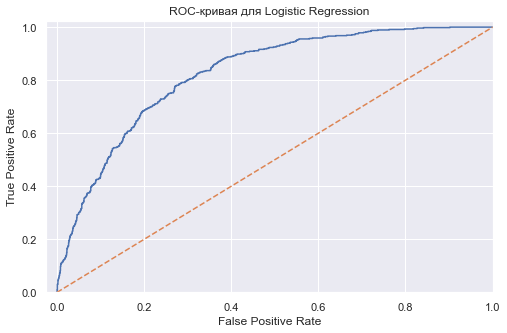

In [37]:
lr = LogisticRegression(random_state=12345, n_jobs=-1)
lr_param = {'C' : np.linspace(0.001, 10, 20, 50),
           'solver' : ['liblinear', 'lbfgs'],
           'penalty' : ['l1', 'l2']}
lr_itog = fit_predict_model(lr, lr_param, 'Logistic Regression')


In [38]:
#ранжирование и отбор признаков с помощью Recursive Feature Elimination

rfe = RFE(estimator=LogisticRegression())
model = LogisticRegression(C=2.6323157894736844, n_jobs=-1, random_state=12345, solver='liblinear')

pipe = Pipeline([('Feature Selection', rfe), ('Model', model)])
pipe.fit(os_X_train, os_y_train)
rfe2 = pd.DataFrame(rfe.support_, index=os_X_train.columns, columns=['Rank'])
cols = rfe2.index
os_X_train3 = os_X_train[cols]

In [39]:
import statsmodels.api as sm
logit_model=sm.Logit(os_y_train,os_X_train3)
result=logit_model.fit()
print(result.summary2())
coef = pd.DataFrame(result.params, columns=['coef'])
coef['coef'] = abs(coef['coef'])
coef = coef.sort_values(by='coef', ascending=False)
print("\nНаиболее значимые параметры:\n", coef.head())
print("\nНаименее значимые параметры:\n", coef.tail())

Optimization terminated successfully.
         Current function value: 0.451375
         Iterations 7
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.349    
Dependent Variable:         target                  AIC:                     6583.5259
Date:                       2021-07-31 15:54        BIC:                     6735.0603
No. Observations:           7244                    Log-Likelihood:          -3269.8  
Df Model:                   21                      LL-Null:                 -5021.2  
Df Residuals:               7222                    LLR p-value:             0.0000   
Converged:                  1.0000                  Scale:                   1.0000   
No. Iterations:             7.0000                                                    
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     

### RandomForest Classifier

Лучшая оценка на валидации:  0.9236026665284746
Лучшие гиперпараметры модели на валидации:  {'max_depth': 16, 'n_estimators': 190}
Лучшая модель:  RandomForestClassifier(max_depth=16, n_estimators=190, random_state=12345)

classification_report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1552
           1       0.57      0.69      0.62       561

    accuracy                           0.78      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.78      0.78      2113

ROC-AUC:  0.8367


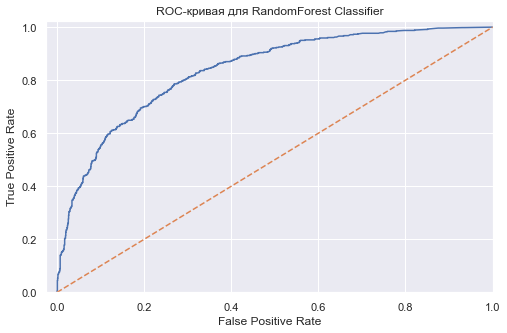

In [40]:
rf = RandomForestClassifier(random_state=12345)
rf_params = {'n_estimators' : range(10, 200, 20), 
             'max_depth' : range(1, 22, 3)}
rf_itog = fit_predict_model(rf, rf_params, 'RandomForest Classifier')

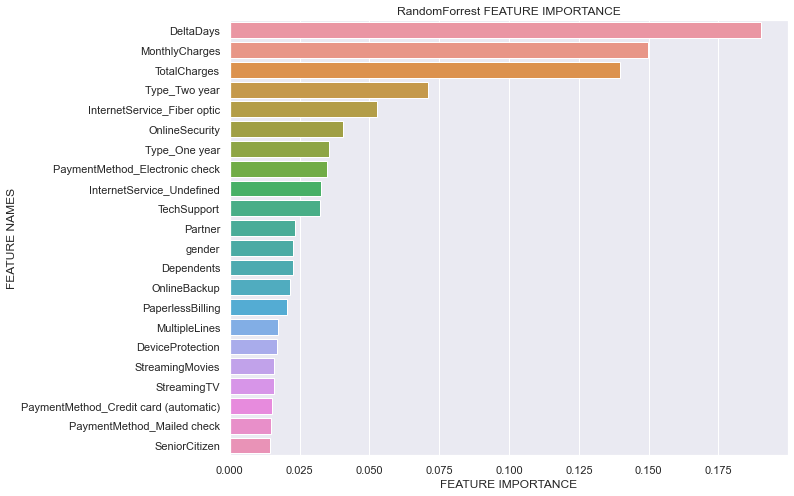

In [41]:
plot_feature_importance(rf_itog, X_train.columns,'RandomForrest')

### CatBoost Classifier

Лучшая оценка на валидации:  0.9638832480653794
Лучшие гиперпараметры модели на валидации:  {'depth': 2, 'iterations': 250, 'learning_rate': 0.78}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x7faa09b845d0>

classification_report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1552
           1       0.82      0.76      0.79       561

    accuracy                           0.89      2113
   macro avg       0.87      0.85      0.86      2113
weighted avg       0.89      0.89      0.89      2113

ROC-AUC:  0.9281


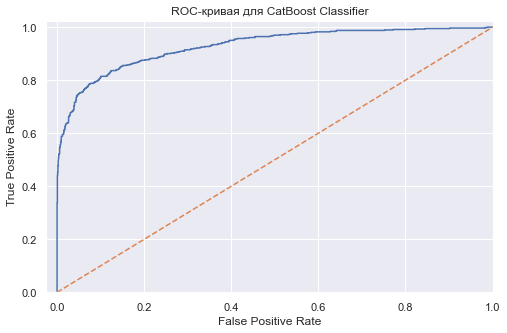

In [42]:
cat = CatBoostClassifier(verbose=False, random_state=12345)
cat_params = {'iterations' : range(248, 253, 1), 
              'depth' : range(2, 6, 2), 
              'learning_rate' : (0.77, 0.78, 0.79)}
cat_itog = fit_predict_model(cat, cat_params, 'CatBoost Classifier')

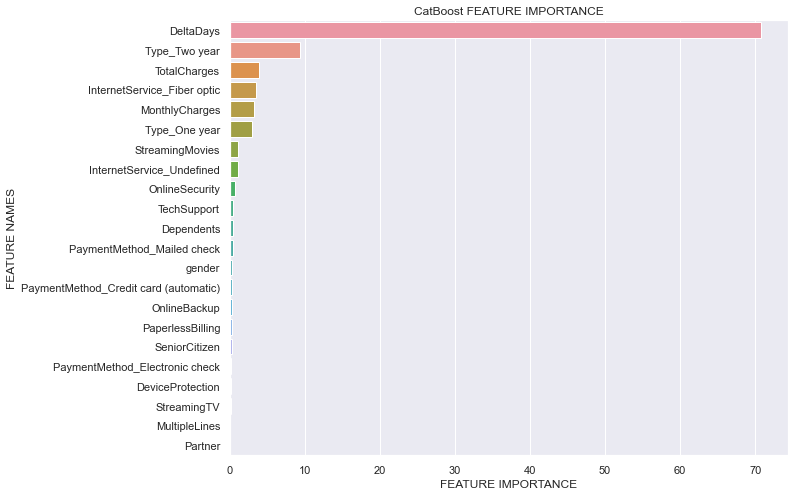

In [43]:
plot_feature_importance(cat_itog, X_train.columns,'CatBoost')

### LGBM Classifier

Лучшая оценка на валидации:  0.9549813743068217
Лучшие гиперпараметры модели на валидации:  {'learning_rate': 0.5272631578947369, 'max_depth': 3, 'n_estimators': 410}
Лучшая модель:  LGBMClassifier(learning_rate=0.5272631578947369, max_depth=3, n_estimators=410,
               random_state=12345)

classification_report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1552
           1       0.75      0.71      0.73       561

    accuracy                           0.86      2113
   macro avg       0.82      0.81      0.82      2113
weighted avg       0.86      0.86      0.86      2113

ROC-AUC:  0.9082


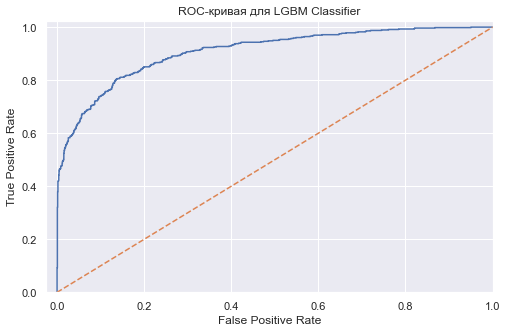

In [44]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=12345)
lgbm_param = {'n_estimators': range(350, 500, 30),
                  'max_depth': range(3, 8, 2),
             'learning_rate': np.linspace(0.001, 10, 20, 50)}

lgbm_itog = fit_predict_model(lgbm, lgbm_param, 'LGBM Classifier')

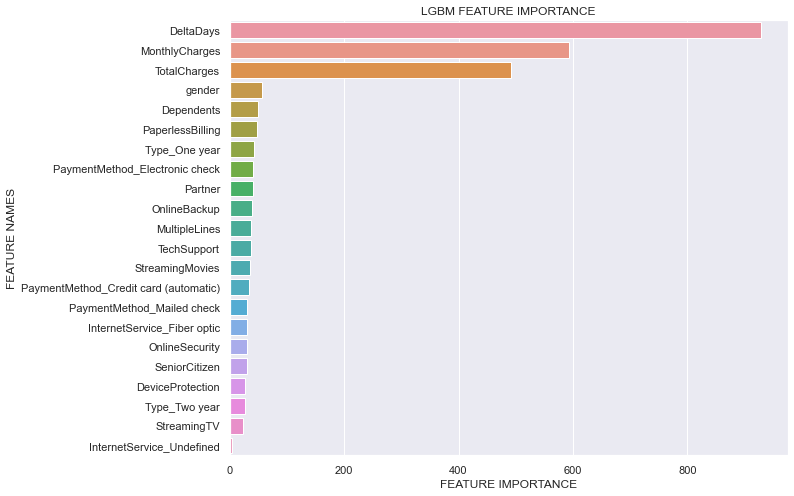

In [45]:
plot_feature_importance(lgbm_itog, X_train.columns, 'LGBM')

### XGBoost 

Лучшая оценка на валидации:  0.9559515516990086
Лучшие гиперпараметры модели на валидации:  {'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 630}
Лучшая модель:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.05, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=630, n_jobs=8,
              num_parallel_tree=1, random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=12345, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

classification_report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1552
           1       0.74      0.73      0.74       561

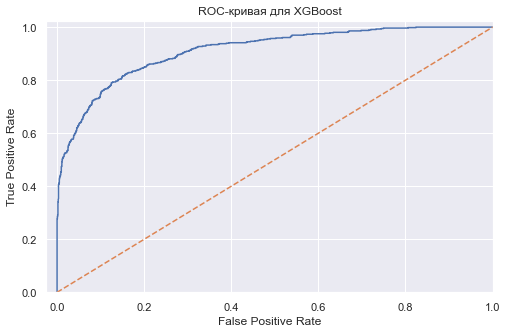

In [46]:
xgb = XGBClassifier(objective= 'binary:logistic',eval_metric = "logloss",seed=12345)
xgb_params = {
    'max_depth': range (5, 8, 1),
    'n_estimators': range(550, 650, 20),
    'learning_rate': [0.1, 0.01],
    'gamma': [0.05,0.01]
}
xgb_itog = fit_predict_model(xgb, xgb_params, 'XGBoost')

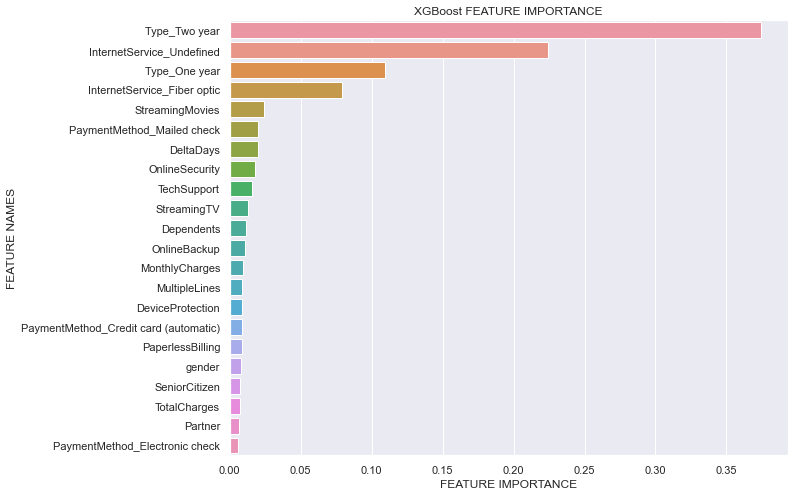

In [47]:
plot_feature_importance(xgb_itog, X_train.columns, 'XGBoost')

In [48]:
results = pd.DataFrame(data = [roc_auc_list, f1_list, accuracy_list, fit_predict_time_list], 
                       index = ['ROC-AUC', 'F1-Score', 'Accuracy', 'Time_seconds'],
                      columns = ['Logistic Regression', 'RandomForrest', 'CatBoost', 'LGBM', 'XGBoost']).T
results['Time_seconds'] = results['Time_seconds'].astype('int')

In [49]:
results

,ROC-AUC,F1-Score,Accuracy,Time_seconds
Logistic Regression,0.8246,0.6154,0.7421,10
RandomForrest,0.8367,0.6228,0.7776,78
CatBoost,0.9281,0.7908,0.8926,41
LGBM,0.9082,0.7306,0.8604,103
XGBoost,0.9115,0.7361,0.8609,496


### Вывод
В ходе подготовки к пострению моделей мы совершили следующие действия:
- сделали OHE кодирование, для категориальных признаков, где больше 2 уникальных переменных 
- сделали Over Sampling методом SMOTE для обучающего набора данных
- лучшие результаты показали алгоритмы градиентного бустинга - CatBoost (ROC-AUC = 0.93, Accuracy = 0.89, F1-Score = 0.79), XGBoost (ROC-AUC = 0.91, Accuracy = 0.86, F1-Score = 0.74) и LGBM (ROC-AUC = 0.91, Accuracy = 0.86, F1-Score = 0.73)
- Важнейшими признаками для большинства моделей стали: длительность жизненного цикла клиента, признаки связанные с расходами клиента (стоимость ежемесячного тарифа и общие расходы), тип оплаты (ежемесячная, ежегодная) и типо подключения интернета
- Также я обратил внимание, что XGBoost - это единственный алгоритм, у которого среди значимых признаков не оказалось числовых значений, а одним из самых важных признаков стали пропуски в типе интернет сервиса
- Наименнее важными признаками для большинства алгоритмов стали: наличие супруга(и), стриминг ТВ, способ оплаты (наличные или безналичные) и пол клиента.

## Общий вывод

На этапе предобработки данных мы пришли к следующим выводам:
- в данных присутствуют пропуски;
- в столбце TotalCharges для новых пользователей присвоено пустое значение, а сам столбец перевести в тип float;
- следует изменить тип столбцов BeginDate, EndDate в datetime;
- дубликаты отсутствуют;
- столбец EndDate содержит 5 уникальных значений, среди которых большинство "No"

Затем мы приступили к исследованию данных, в ходе которого пришли к выводу,что данные несбалансирваны, кол-во ушедших клиентов 1869, кол-во текущих клиентов 5174. А также выдвинули гипотезы:
- распределение типа подключения интернета для текущих клиентов примерно равное, однако большинство ушедших клиентов пользовались оптоволоконным кабелем
- доля ушедших клиентов, которые пользовались ежемесячной оплатой услуг намного больше аналогичной доли текущих клиентов
- распределение способа оплаты для текущих клиентов примерно равное, но ушедшие клиенты чаще оплачивали счета почтовыми переводами
- большинство ушедших клиентов имели высокий ежемесячный платеж 60-100 долл
- большинство ушедших клиентов разорвали договор в первый год пользования
- ушедшие клиенты чаще текущих клиентов пользовались безналичной оплатой
- ушедшие клиенты реже текущих имеют супруга(у) и иждивенцев
- ушедшие клиенты реже текущих пользовались блокировкой небезопасных сайтов, антивирусом и тех. поддерджкой, возможно это именно те доп. услуги, которые заставляют клиента остаться с компанией
- ушедшие клиенты чаще текущих пользовались стриминговыми сервисами, возможно их не устраивал текущий сервис по данной услуге и это поспособствовало их уходу

Перед постоением моделей с данными были проделаны следующие этапы:
В ходе подготовки к пострению моделей мы совершили следующие действия:
- сделали OHE кодирование (обучили на тренировочном наборе данных), для категориальных признаков, где больше 2 уникальных переменных 
- сделали Over Sampling методом SMOTE для обучающего набора данных

Итоги построения моделей:
- лучшие результаты показали алгоритмы градиентного бустинга - CatBoost (ROC-AUC = 0.93, Accuracy = 0.89, F1-Score = 0.79), XGBoost (ROC-AUC = 0.91, Accuracy = 0.86, F1-Score = 0.74) и LGBM (ROC-AUC = 0.91, Accuracy = 0.86, F1-Score = 0.74)
- Важнейшими признаками для большинства моделей стали: длительность жизненного цикла клиента, признаки связанные с расходами клиента (стоимость ежемесячного тарифа и общие расходы), тип оплаты (ежемесячная, ежегодная) и типо подключения интернета
- Также я обратил внимание, что XGBoost - это единственный алгоритм, у которого среди значимых признаков не оказалось числовых значений, а одним из самых важных признаков стали пропуски в типе интернет сервиса
- Наименнее важными признаками для большинства алгоритмов стали: наличие супруга(и), стриминг ТВ, способ оплаты (наличные или безналичные) и пол клиента.

## Отчет по проекту

1) Какие пункты плана были выполнены, а какие — нет (поясните почему)?  

Пройдемся детально по изначальному плану:
- Провести предобработку данных (проверить типы, пропуски, дубликаты, аномальные значения)  
Данный пункт был полностью выполнен. После объединения всех таблиц в одну образовались пропуски, которые были заполнены по смыслу, было проверено наличие дубликатов, была проведена работа с типами данных, а также выявлены странные пустые значения (возможно пробелы)
- Исследовать данные (изучить различные зависимости, построить предварительные выводы)  
Было проведено исследование всех параметров и выдвинуто несколько гипотез на основе исследования
- Провести подготовку данных к моделированию (исследовать баланс классов, исключение признаков, нормализовать данные)  
Баланс классов был изучен и был выполнен over-sampling алгоритмом smote, была проведена нормализация данных а также после пострения моделей была изучена важность каждого признака
- Построение моделей и оптимизация их гиперпараметров  
Построил 5 моделей, для каждой провел оптимизацию гиперпараметров
- Выбор итоговой модели и вывод  
Лучшей моделью стал Катбуст со значением ROC-AUC 0.93

Таким образом, все пункты изначального плана были выполнены. 

2) Какие трудности возникли и как вы их преодолели?  
Основные трудности для меня были связаны с написание кода, например прежде я не знал, как через цикл вывести два графика в ряд по горизонтали, чтобы их удобней было сравнивать. Также впервые использовал такой метод, как feature_importance для обозначения важности признаков.

3) Какие ключевые шаги в решении задачи выделили?  
Мне кажется, ключевой шаг в работе с любыми данными - это правильная их обработка и интерпретация. Стоит отметить, что мы почти не удаляли отсутствующие признаки, а нашли им замену исходя из логики датасета. Другим необходимым шагом была - борьба с дисбалансом классов и нормализация значений признаков. Также важный шагом является изучение влияния признаков на нашу целевую метрику, ну и оценка результатов правильными метриками.

4) Какая ваша итоговая модель и какое у неё качество?  
Моя итоговая модель - Катбуст. Он показал следующие метрики: ROC-AUC = 0.93, F1-Score = 0.79, Accuracy = 0.8926	